# Etapa 01: Análise Exploratória dos Dados (Data Understanding)

                Age  Time_on_platform  ...    Avg_rating       Churned
count  66607.000000      56464.000000  ...  60614.000000  61148.000000
mean      43.511072       4385.848505  ...      3.002252      0.243066
std       15.043158       2526.580859  ...      1.154963      0.428938
min       18.000000          0.000000  ...      1.000000      0.000000
25%       30.000000       2196.000000  ...      1.990000      0.000000
50%       43.000000       4384.000000  ...      3.010000      0.000000
75%       57.000000       6573.000000  ...      4.000000      0.000000
max       69.000000       8759.000000  ...      5.000000      1.000000

[8 rows x 7 columns]
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 77884 entries, 0 to 77883
Data columns (total 10 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Age                     66607 non-null  float64
 1   Gender                  63368 non-null  object 
 2   Time_on_platf

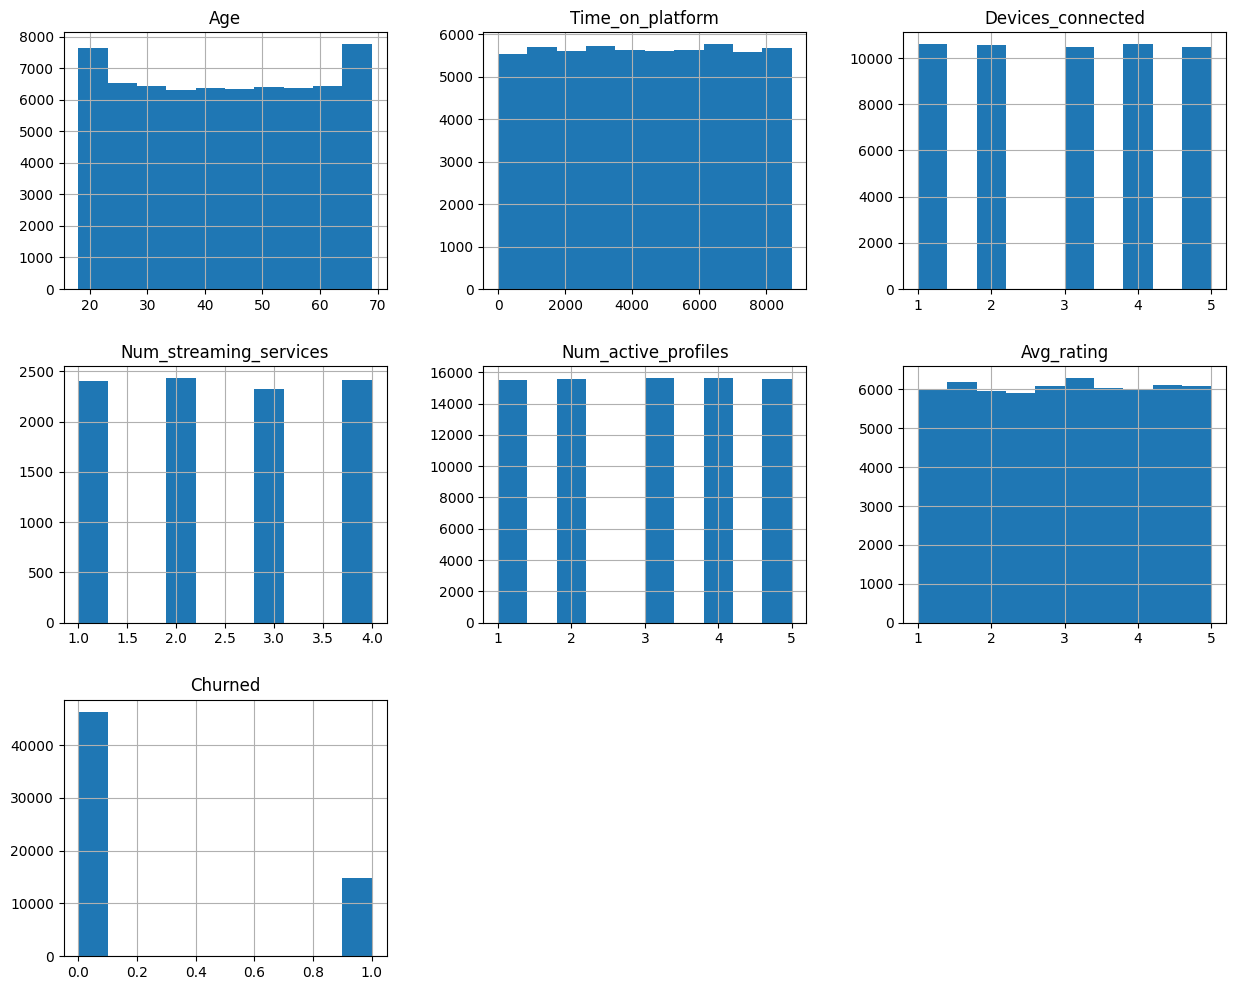

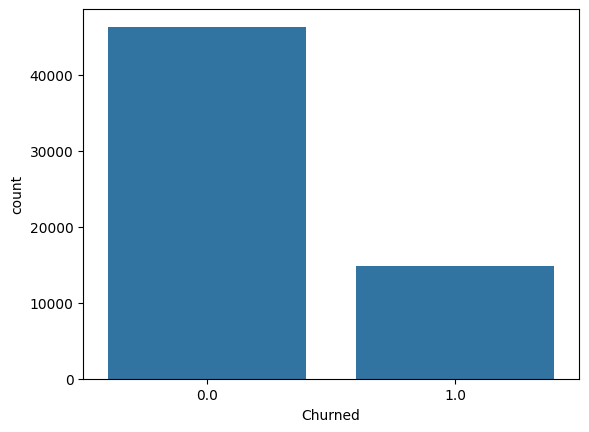

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import ConfusionMatrixDisplay, classification_report
from sklearn.ensemble import RandomForestClassifier

df = pd.read_csv('streaming_data.csv')

print(df.describe())
print(df.info())
print(df.isna().sum())

df.hist(figsize=(15, 12))
plt.show()

sns.countplot(x='Churned', data=df)
plt.show()

# Etapa 02: Tratamento dos Dados (Data Preparation)

In [43]:
df['Time_on_platform'] = df['Time_on_platform'].fillna(0)
df['Num_streaming_services'] = df['Num_streaming_services'].fillna(0)
df['Churned'] = df['Churned'].fillna(0)
df['Avg_rating'] = df['Avg_rating'].fillna(0)
df['Devices_connected'] = df['Devices_connected'].fillna(0)

df.dropna(subset=['Gender', 'Subscription_type', 'Age'], inplace=True)

df['Churned'] = df['Churned'].replace({0: 'No', 1: 'Yes'})

df['Time_on_platform'] = df['Time_on_platform'].astype(int)
df['Num_streaming_services'] = df['Num_streaming_services'].astype(int)
df['Avg_rating'] = df['Avg_rating'].astype(int)
df['Devices_connected'] = df['Devices_connected'].astype(int)

print(df.head())

    Age  Gender  Time_on_platform  ...  Avg_rating Churned                               User_id
0  49.0    Male              4700  ...           0      No  a271aa56-bcfc-4f0a-91f7-b773de6b86a4
1  69.0  Female              6107  ...           2      No  fe14b048-770b-4619-8ec6-485b0969ae31
2  44.0    Male              6374  ...           1     Yes  0283dffd-6684-4a05-9c6f-c02098a6849d
3  26.0    Male                 0  ...           0      No  c316f2f5-3403-4a0a-82c2-c98e4b3379d2
5  54.0    Male              3024  ...           0      No  a1df3a13-9255-4d00-8a9d-20565fefaab9

[5 rows x 10 columns]


# Etapa 03: Modelagem dos Dados - Regressão Logística

In [44]:
X = df.drop('Churned', axis=1)
y = df['Churned']

colunas_nao_numericas = X.select_dtypes(include=['object']).columns

le = LabelEncoder()
for coluna in colunas_nao_numericas:
  X[coluna] = le.fit_transform(X[coluna])

In [45]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [46]:
model = LogisticRegression(max_iter=5000, class_weight='balanced')
model.fit(X_train, y_train)
print(f"Coeficientes: {model.coef_}")
print(f"Intercepto: {model.intercept_}")

Coeficientes: [[ 3.50813395e-05  2.06488110e-02 -8.19760029e-06  5.91169770e-03
  -6.95626231e-03  2.77764007e-02  3.88254997e-03  1.84900336e-02
  -1.54612907e-06]]
Intercepto: [-0.02382878]


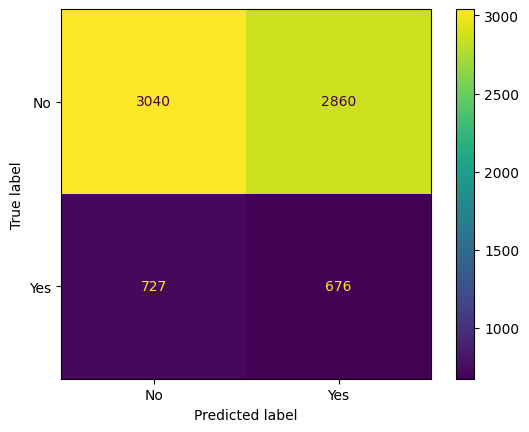

              precision    recall  f1-score   support

          No       0.81      0.52      0.63      5900
         Yes       0.19      0.48      0.27      1403

    accuracy                           0.51      7303
   macro avg       0.50      0.50      0.45      7303
weighted avg       0.69      0.51      0.56      7303



In [47]:
y_pred = model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(model, X_test, y_test)
plt.show()

print(classification_report(y_test, y_pred))

# Etapa 04: Modelagem dos Dados - Tunning

In [48]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

param_grid = {
    'C': [0.1, 1, 10, 100, 1000],
    'penalty': ['l1','l2'],
    'solver': ['liblinear']
}

grid_search = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, scoring='accuracy')
grid_search.fit(X_train_scaled, y_train)

best_model = grid_search.best_estimator_
print(f"Melhor modelo: {best_model}")

Melhor modelo: LogisticRegression(C=0.1, max_iter=5000, penalty='l1', solver='liblinear')


In [49]:
y_pred_proba = best_model.predict_proba(X_test_scaled)
print(y_pred_proba)

print(X_train.isnull().sum())
print(X_test.isnull().sum())

[[0.81564986 0.18435014]
 [0.80335794 0.19664206]
 [0.81066156 0.18933844]
 ...
 [0.8087103  0.1912897 ]
 [0.80433713 0.19566287]
 [0.80155852 0.19844148]]
Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
User_id                   0
dtype: int64
Age                       0
Gender                    0
Time_on_platform          0
Devices_connected         0
Subscription_type         0
Num_streaming_services    0
Num_active_profiles       0
Avg_rating                0
User_id                   0
dtype: int64


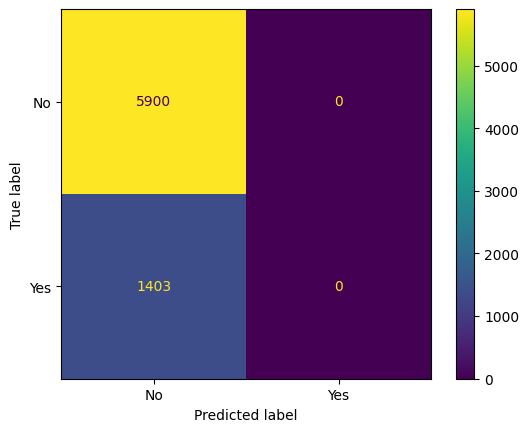

              precision    recall  f1-score   support

          No       0.81      1.00      0.89      5900
         Yes       0.00      0.00      0.00      1403

    accuracy                           0.81      7303
   macro avg       0.40      0.50      0.45      7303
weighted avg       0.65      0.81      0.72      7303



In [50]:
# Avaliação do modelo
y_pred = best_model.predict(X_test_scaled)

ConfusionMatrixDisplay.from_estimator(best_model, X_test_scaled, y_test)
plt.show()

print(classification_report(y_test, y_pred, zero_division=0))

# Etapa 05: Modelagem de Dados - Random Forest

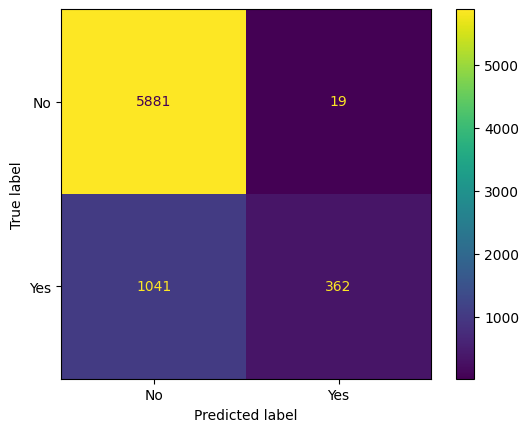

              precision    recall  f1-score   support

          No       0.85      1.00      0.92      5900
         Yes       0.95      0.26      0.41      1403

    accuracy                           0.85      7303
   macro avg       0.90      0.63      0.66      7303
weighted avg       0.87      0.85      0.82      7303



In [51]:
rf_model = RandomForestClassifier()
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

ConfusionMatrixDisplay.from_estimator(rf_model, X_test, y_test)
plt.show()

print(classification_report(y_test, y_pred_rf))